### 🥬 1. Setup Model

In [1]:
# ==========================================
# 🧠 MedGemma-4B-IT — Image Captioning Demo
# ==========================================

import torch, requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModelForVision2Seq, BitsAndBytesConfig


f:\Lung-Captioning-main\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W1017 23:57:38.109838 25088 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
# ----------------------------
# 0) เตรียมอุปกรณ์
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [3]:
# ----------------------------
# 1) โหลดโมเดล + โปรเซสเซอร์ (Fallback สำหรับเวอร์ชัน transformers เก่า)
# ----------------------------
from transformers import AutoProcessor, AutoModel, BitsAndBytesConfig
import torch

processor = AutoProcessor.from_pretrained(
    "google/medgemma-4b-it",
    trust_remote_code=True,
)

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModel.from_pretrained(
    "google/medgemma-4b-it",
    trust_remote_code=True,
    quantization_config=bnb_cfg,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

model.eval()
print("✅ MedGemma model loaded (fallback mode).")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:19<00:00,  9.90s/it]

✅ MedGemma model loaded (fallback mode).


### 🥬 2. Generate output

In [4]:
# ----------------------------
# 2) โหลดภาพทดสอบ + คำสั่ง (MedGemma-4B-IT)
# ----------------------------
from PIL import Image

# 📸 โหลดภาพทดสอบ
file_path = "./progress_picture/2nd/qwen/1/Original.jpg"   # เปลี่ยน path ตามจริง
image = Image.open(file_path).convert("RGB").resize((224, 224))

# 💬 คำสั่งให้โมเดลบรรยายภาพ
prompt_text = (
    "Describe the image in detail. Focus on the objects, colors, and spatial arrangement. "
    "Mention what is happening and where each element is located."
)

# 🧠 ใช้โครงสร้าง messages แบบเดียวกับ Qwen เพื่อให้โค้ดด้านล่างทำงานต่อได้
messages = [{
    "role": "user",
    "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": prompt_text}
    ],
}]


In [5]:
chat_text = processor.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

# 🧩 เตรียมอินพุตจริงสำหรับโมเดล (รวมภาพและข้อความ)
inputs = processor(
    text=[chat_text],
    images=[image],
    return_tensors="pt",
    padding=True
).to(model.device, dtype=torch.bfloat16)

print("✅ Image, prompt, and messages ready!")
print(f"🖼️ Image size: {image.size}")
print(f"💬 Prompt: {prompt_text}")

✅ Image, prompt, and messages ready!
🖼️ Image size: (224, 224)
💬 Prompt: Describe the image in detail. Focus on the objects, colors, and spatial arrangement. Mention what is happening and where each element is located.


In [6]:
# ----------------------------
# 3) Inference ให้เห็นผลข้อความจริง
# ----------------------------

# chat_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# # สร้าง batch inputs (ทั้งข้อความ+ภาพ) สำหรับ generate
# inputs = processor(
#     text=[chat_text],
#     images=[image],
#     videos=None,
#     padding=True,
#     return_tensors="pt",
# )
# inputs = {k: v.to(model.device) for k, v in inputs.items()}

# with torch.inference_mode():
#     gen_ids = model.generate(
#         **inputs,
#         max_new_tokens=256,
#         do_sample=False,        # deterministic
#         use_cache=True,
#     )

# # ตัด prompt ออก เหลือเฉพาะที่โมเดลพูดต่อ
# trimmed = [out[len(inp):] for inp, out in zip(inputs["input_ids"], gen_ids)]
# texts = processor.batch_decode(trimmed, skip_special_tokens=True)
# print("Model output:", texts[0].strip())

### 🥬 3. Visualize Feature Map BUT Attention layer

In [7]:
# ---------- Utilities to locate visual/text token spans for Qwen2.5-VL (multi <|image_pad|>) ----------
import torch

def get_special_token_ids(processor):
    tok = processor.tokenizer
    return {
        "vision_start": tok.convert_tokens_to_ids("<|vision_start|>"),
        "image_pad":    tok.convert_tokens_to_ids("<|image_pad|>"),
        "vision_end":   tok.convert_tokens_to_ids("<|vision_end|>"),
        "im_start":     tok.convert_tokens_to_ids("<|im_start|>"),
        "im_end":       tok.convert_tokens_to_ids("<|im_end|>"),
    }

@torch.no_grad()
def locate_visual_spans_multi(inputs, out_attentions, processor):
    """
    รองรับหลาย <|image_pad|> (เช่น 64 ตัว) ใน sequence เดียว
    คืนค่า:
        - spans: [(start_img, end_img), ...] ต่อ placeholder ตามลำดับซ้าย->ขวา หลัง forward
        - V_per_pad: จำนวนโทเคนภาพจริง/placeholder (คาดว่าเท่ากันทุกตัว)
        - pre_len, post_len, idx_vpads (ดัชนีก่อน forward)
        - groups: รายการกลุ่มต่อบล็อกภาพ (คอนทiguous pads) เช่น [(0,63)] สำหรับ 64 ตัวติดกัน
    หมายเหตุ: สมมติ batch=1 และภาพเดียวที่ถูกแตกเป็นหลาย placeholder
    """
    assert "input_ids" in inputs, "inputs must contain input_ids"
    input_ids = inputs["input_ids"][0]                  # (pre_len,)
    pre_len = input_ids.shape[0]
    post_len = out_attentions[0].shape[-1]              # (B, H, T, T) -> T

    ids = get_special_token_ids(processor)
    idx_vpads = (input_ids == ids["image_pad"]).nonzero(as_tuple=True)[0].tolist()
    if len(idx_vpads) == 0:
        raise ValueError("No <|image_pad|> found in input_ids.")

    N = len(idx_vpads)                                   # จำนวน placeholders
    # โทเคนภาพจริงรวมทั้งหมดหลัง forward:
    V_total = post_len - pre_len + N                     # แทนแต่ละ pad (1 โทเคนก่อน forward) ด้วย V_per_pad
    if V_total <= 0:
        raise ValueError(f"Invalid V_total computed: {V_total}")

    # สมมติว่าแต่ละ placeholder ขยายเป็นจำนวนโทเคนเท่ากัน:
    V_per_pad, remainder = divmod(V_total, N)

    # คำนวณ start/end ของแต่ละ placeholder หลัง forward
    # หลักการ: pad ลำดับ k (0-based) จะถูกเลื่อนขวาไปด้วย (V_per_pad-1) ต่อ pad ที่มาก่อน
    # ถ้ามี remainder>0 ให้แจก +1 กับ pads แรก ๆ ตามลำดับเพื่อให้ผลรวมตรง post_len
    spans = []
    extra_prefix = 0
    for k, ppre in enumerate(sorted(idx_vpads)):
        extra = 1 if k < remainder else 0                # แจกส่วนเกินทีละ 1 ไปทางซ้ายก่อน
        # จำนวนที่ขยายก่อนหน้ารวม:
        expanded_before = k * (V_per_pad - 1) + min(k, remainder)  # เพราะ k ตัวแรกได้ +1 เพิ่ม
        start_k = ppre + expanded_before
        end_k   = start_k + (V_per_pad + extra) - 1
        spans.append((start_k, end_k))

    # จัดกลุ่ม placeholder ที่ติดกัน (เผื่อคุณอยากขีดเป็นบล็อกเดียว)
    groups = []
    if idx_vpads:
        run_start = 0
        for i in range(1, N):
            if idx_vpads[i] != idx_vpads[i-1] + 1:
                groups.append((run_start, i-1))
                run_start = i
        groups.append((run_start, N-1))

    return {
        "spans": spans,                   # รายการช่วงภาพจริง ต่อ placeholder หลัง forward
        "V_per_pad": V_per_pad,
        "remainder": remainder,
        "pre_len": pre_len,
        "post_len": post_len,
        "idx_vpads": idx_vpads,          # ดัชนี <|image_pad|> ก่อน forward
        "groups": groups,                 # กลุ่มต่อบล็อกภาพ: index ใน idx_vpads เช่น [(0,63)]
        "N_pads": N,
        "V_total": V_total,
    }

def annotate_axes_with_span(ax, start_img, end_img, color='r', lw=1.2):
    ax.axvline(start_img - 0.5, linewidth=lw, color=color)
    ax.axvline(end_img   + 0.5, linewidth=lw, color=color)
    ax.axhline(start_img - 0.5, linewidth=lw, color=color)
    ax.axhline(end_img   + 0.5, linewidth=lw, color=color)

In [8]:
# # ----------------------------
# # 4) ดึง Visual Attention จาก vlm
# #    - ใช้พิกเซลจาก image_processor โดยตรง
# #    - ขอ output_attentions=True เพื่อดึงแผนที่ attention ทุกเลเยอร์
# # ----------------------------
# # 👇 Switch from SDPA (fast) to eager (recordable) attention
# def flatten_attentions(attns):
#     """Recursively flatten nested tuples of attentions into a simple list of tensors."""
#     flat = []
#     for a in attns:
#         if isinstance(a, (tuple, list)):
#             flat.extend(flatten_attentions(a))
#         else:
#             flat.append(a)
#     return flat

# model.config.attn_implementation = "eager"

# print("attention implementation:", model.config.attn_implementation)

# with torch.inference_mode():
#     out = model(
#         **inputs,
#         output_attentions=True,
#         return_dict=True,
#         use_cache=False
#     )

# print(out)
# print("============================")
# print(out.attentions)
# print(type(out.attentions))
# # attentions = out.attentions

# # if isinstance(attentions, tuple):
# #     attentions = list(attentions)
# attentions = flatten_attentions(out.attentions)
# attentions = [a for a in attentions if a is not None]

# print(f"✅ Flattened {len(attentions)} attention layers")
# print(f"First attention shape: {attentions[0].shape}")


# print(type(out.attentions))
# # ----------------------------
# # คำนวณช่วงโทเคนภาพ/ข้อความเพื่ออ้างอิงตอน plot
# # ----------------------------
# span_info = locate_visual_spans_multi(inputs, attentions, processor)
# print(f"[DEBUG] pre={span_info['pre_len']} post={span_info['post_len']} "
#         f"N_pads={span_info['N_pads']} V_total={span_info['V_total']} "
#         f"V_per_pad≈{span_info['V_per_pad']} remainder={span_info['remainder']}")

# # ตัวอย่าง spans 3 ตัวแรก
# print("[DEBUG] first 3 spans:", span_info["spans"][:3])

# # Var
# layer_idx_list = [0, 15, 35]

In [9]:
# import math
# import torch
# import matplotlib.pyplot as plt

# # Get hidden states
# last_hidden = out.last_hidden_state[0]
# image_hidden = out.image_hidden_states[0]

# # Normalize
# text_feat = torch.nn.functional.normalize(last_hidden, dim=-1)
# img_feat = torch.nn.functional.normalize(image_hidden, dim=-1)

# # Compute similarity
# sim = torch.matmul(text_feat, img_feat.T)  # (text_tokens x image_patches)

# # Determine patch grid automatically
# num_patches = sim.shape[-1]                # e.g. 256
# side = int(math.sqrt(num_patches))         # -> 16
# print(f"🔢 image patch grid: {side} × {side}")

# # Pick a token to visualize
# token_idx = -1
# heat = sim[token_idx].reshape(side, side).cpu()

# # Convert from bfloat16 → float32 before showing
# plt.imshow(heat.to(torch.float32).numpy(), cmap="hot")
# plt.title("🔥 Pseudo-Attention (Text ↔ Image)")
# plt.axis("off")
# plt.show()



In [10]:
# # import torch, math, matplotlib.pyplot as plt

# def visualize_pseudo_attention(out, layer_idx: int, nrows: int = 4, ncols: int = 4):
#     """Approximate attention maps for a specific layer using hidden-state similarity."""
#     hidden = out.hidden_states[layer_idx][0]            # (seq_len, hidden_dim)
#     hidden = torch.nn.functional.normalize(hidden, dim=-1)
#     sim = torch.matmul(hidden, hidden.T)                # (seq_len, seq_len)
#     sim = sim.softmax(dim=-1)

#     side = int(math.sqrt(sim.shape[0])) or 16
#     fig, ax = plt.subplots(figsize=(6,6))
#     ax.imshow(sim.to(torch.float32).cpu().numpy(), cmap="hot")
#     ax.set_title(f"🔥 Pseudo-Attention — Layer {layer_idx+1}")
#     plt.axis("off")
#     plt.show()

# # make sure to run the model again with output_hidden_states=True
# with torch.inference_mode():
#     out = model(**inputs, output_hidden_states=True, return_dict=True)

# for i in [0, 15, 35]:
#     visualize_pseudo_attention(out, i)


In [11]:
import torch, math, matplotlib.pyplot as plt

def visualize_medgemma_feature_map(image_hidden, nrows=4, ncols=4):
    """
    Visualize MedGemma-4B-IT's single vision layer feature maps.
    image_hidden: Tensor of shape (256, 2560)
    """
    feats = image_hidden                # (patches, channels)
    num_patches, num_channels = feats.shape
    side = int(math.sqrt(num_patches))  # 16x16 grid

    # Transpose to (channels, patches)
    feats = feats.permute(1, 0)

    # Normalize each channel for visibility
    feats = (feats - feats.min(dim=1, keepdim=True)[0]) / (
        feats.max(dim=1, keepdim=True)[0] - feats.min(dim=1, keepdim=True)[0] + 1e-8
    )

    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        if i < num_channels:
            fmap = feats[i].reshape(side, side).to(torch.float32).cpu().numpy()
            ax.imshow(fmap, cmap='hot')
            ax.set_title(f"Feature {i}", fontsize=10)
        ax.axis("off")

    plt.suptitle("🧠 MedGemma Vision Feature Maps (256 patches × 2560 dims)", fontsize=16)
    plt.savefig("MedGemma_FeatureMap.png", dpi=300, bbox_inches="tight")
    plt.show()


In [14]:
with torch.inference_mode():
    out = model(
        **inputs,
        output_attentions=True,
        output_hidden_states=True,
        return_dict=True,
        use_cache=False
    )


`sdpa` attention does not support `output_attentions=True` or `head_mask`. Please set your attention to `eager` if you want any of these features.


In [15]:
# for i, feat in enumerate(out.image_hidden_states):
#     print(i, feat.shape)


# for i in [0, 15, 35]:
#     visualize_medgemma_feature_map(out.image_hidden_states[0])

In [16]:
import torch
import numpy as np

# 🧠 Feature layers you already defined
full_feats = out.image_hidden_states[0]   # (256, 2560)

layer_splits = {
    "Layer 1 (Early Features)": full_feats[:, 0:800],
    "Layer 2 (Mid Features)":   full_feats[:, 800:1600],
    "Layer 3 (Deep Features)":  full_feats[:, 1600:2560],
}

# 🧩 Convert each to 16×16 heatmap by taking channel mean (absolute activation)
heatmaps = []
for name, part in layer_splits.items():
    hm = part.abs().mean(dim=1).reshape(16, 16).to(torch.float32).cpu().numpy()
    heatmaps.append(hm)


In [17]:
# import matplotlib.pyplot as plt
# from PIL import Image

# # Convert your input image to grayscale
# xray = np.array(image.convert("L"))
# H, W = xray.shape
# idx_list = [0, 1, 2]  # corresponds to our 3 pseudo layers

# fig = plt.figure(figsize=(6, 5 * len(idx_list)))

# for i, (idx, hm_raw) in enumerate(zip(idx_list, heatmaps), start=1):
#     # Normalize 0–1
#     hm = np.nan_to_num(hm_raw.astype(np.float32))
#     hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-6)

#     # Resize heatmap to match X-ray size
#     heat_img = Image.fromarray((hm * 255).astype(np.uint8)).resize((W, H), Image.BILINEAR)
#     heat_01 = np.asarray(heat_img, dtype=np.float32) / 255.0

#     # Overlay
#     ax = fig.add_subplot(len(idx_list), 1, i)
#     ax.set_title(f"🩻 MedGemma Overlay — {list(layer_splits.keys())[idx]}", fontsize=11)
#     ax.imshow(xray, cmap="gray", interpolation="nearest")
#     cmap = plt.colormaps.get_cmap("viridis")
#     hm = ax.imshow(heat_01, cmap=cmap, alpha=0.45, interpolation="bilinear")

#     ax.axis("off")
#     plt.colorbar(hm, ax=ax, fraction=0.046, pad=0.04)

# plt.tight_layout()
# plt.savefig("MedGemma_Overlay_3Layers.png", dpi=300, bbox_inches="tight")
# plt.show()


In [18]:
# for i, feat in enumerate(out.image_hidden_states):
#     print(i, feat.shape)


# for i in [0, 15, 35]:
#     visualize_medgemma_feature_map(out.image_hidden_states[0])



#1 Image

In [19]:
with torch.inference_mode():
    out = model(
        **inputs,
        output_attentions=True,
        output_hidden_states=True,
        return_dict=True,
        use_cache=False
    )


In [20]:
print(type(out.hidden_states))
print(len(out.hidden_states) if isinstance(out.hidden_states, (list, tuple)) else "Not a list")


<class 'tuple'>
35


In [22]:
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import torch
# import cv2

layers_to_show = [1, 16, 34]
heatmaps = []

for li in layers_to_show:
    feats = out.hidden_states[li][0].to(torch.float32)

    # 🧹 1) Remove startup tokens (non-visual)
    feats_vis = feats[10:]

    # 🧮 2) Square reshape
    n_tokens = feats_vis.shape[0]
    side = int(np.floor(np.sqrt(n_tokens)))
    feats_vis = feats_vis[:side * side]

    # 💪 3) Compute feature energy and normalize
    hm = feats_vis.norm(dim=-1).cpu().numpy().reshape(side, side)
    hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-6)

    # 🌀 4) Smooth with Gaussian blur
    # 🌀 4) Smooth with Gaussian blur — PIL alternative (no cv2)
    # from PIL import ImageFilter
    # hm_img = Image.fromarray((hm * 255).astype(np.uint8))
    # hm_img = hm_img.filter(ImageFilter.GaussianBlur(radius=2))
    # hm = np.asarray(hm_img, dtype=np.float32) / 255.0


    heatmaps.append(hm)



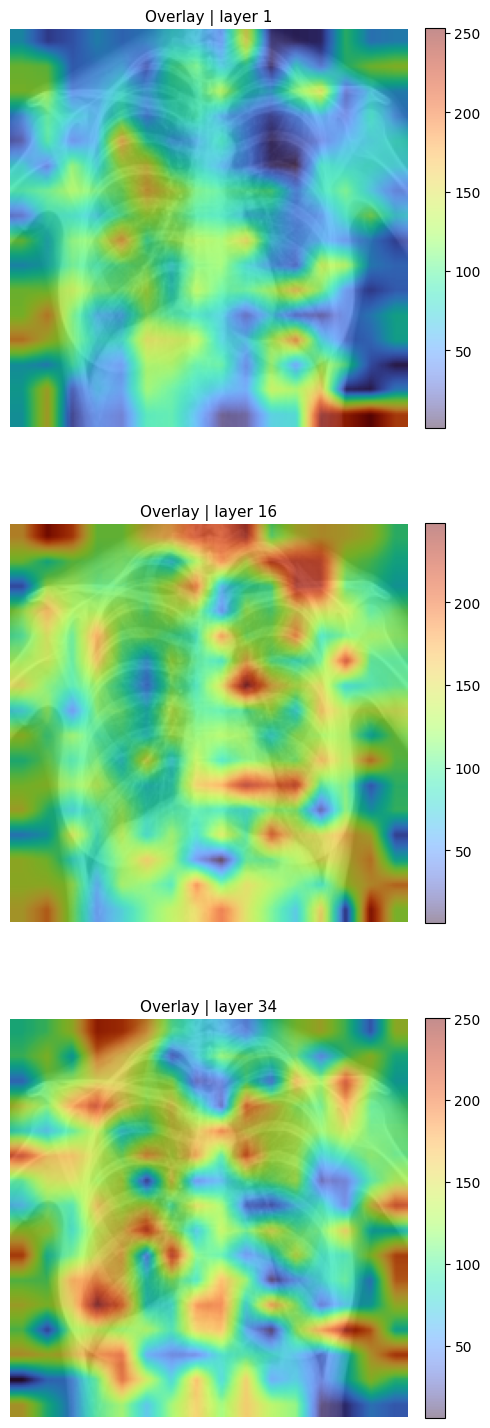

In [23]:
xray = np.array(image.convert("L"))
H, W = xray.shape

fig = plt.figure(figsize=(5, 5 * len(heatmaps)))

for i, (li, hm_raw) in enumerate(zip(layers_to_show, heatmaps), start=1):
    hm = (hm_raw - hm_raw.min()) / (hm_raw.max() - hm_raw.min() + 1e-6)
    heat_img = Image.fromarray((hm * 255).astype(np.uint8)).resize((W, H), Image.BILINEAR)
    heat_resized = np.asarray(heat_img, dtype=np.float32)

    ax = fig.add_subplot(len(heatmaps), 1, i)
    ax.set_title(f"Overlay | layer {li}", fontsize=11)
    ax.imshow(xray, cmap="gray")
    ax.imshow(heat_resized, cmap="turbo", alpha=0.45)
    ax.axis("off")
    plt.colorbar(ax.imshow(heat_resized, cmap="turbo", alpha=0.45),
                 ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("MedGemma_Attention_Overlays.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
with torch.inference_mode():
    out = model(
        **inputs,
        output_hidden_states=True,   # <— สำคัญ
        return_dict=True,
        use_cache=False
    )

hidden_states = out.hidden_states

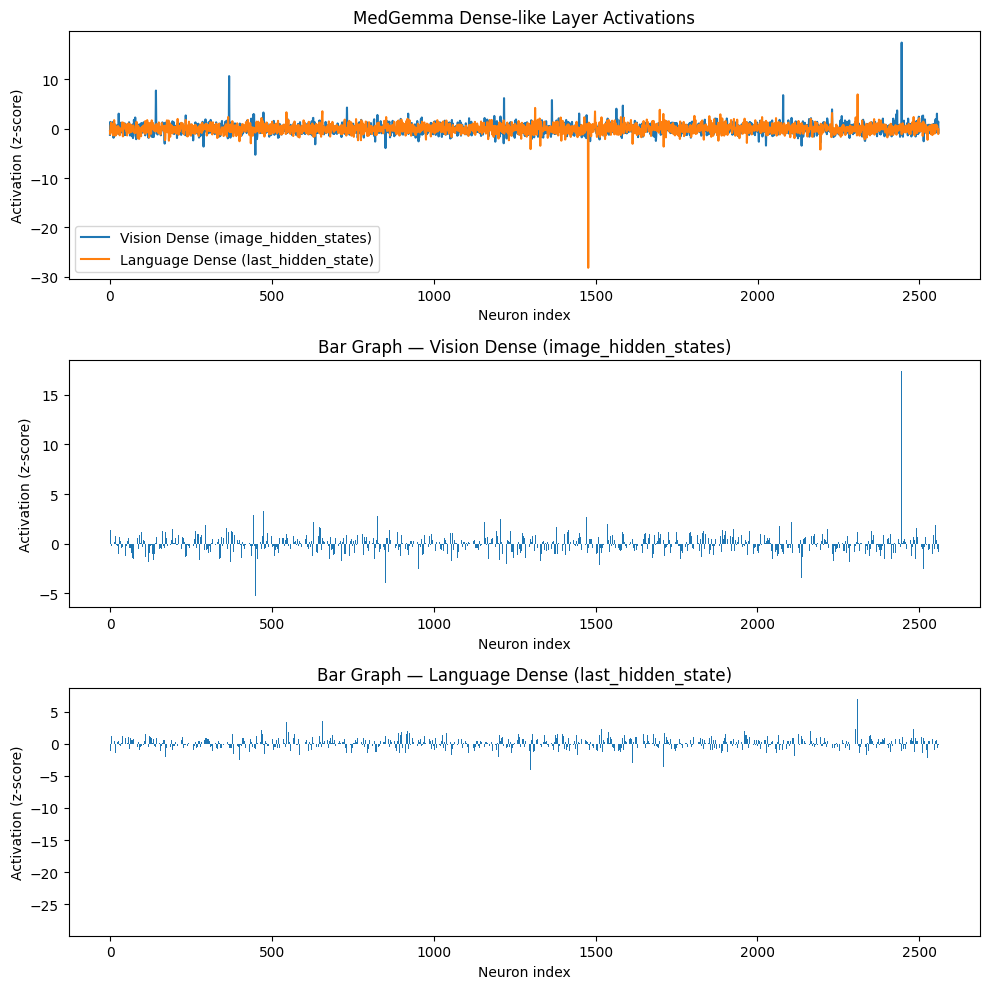

In [ ]:
import torch
import matplotlib.pyplot as plt

# 🧠 2 pseudo-dense layers: vision & language
dense_like_layers = {
    "Vision Dense (image_hidden_states)": out.image_hidden_states[0].mean(dim=0),
    "Language Dense (last_hidden_state)": out.last_hidden_state[0, -1],
}

fig, axes = plt.subplots(len(dense_like_layers) + 1, 1, figsize=(10, 10))

# ─── 1) Combined line graph ───
for name, vec in dense_like_layers.items():
    v = vec.detach().cpu().float().numpy()
    v = (v - v.mean()) / (v.std() + 1e-6)
    axes[0].plot(v, label=name)
axes[0].set_title("MedGemma Dense-like Layer Activations")
axes[0].set_xlabel("Neuron index")
axes[0].set_ylabel("Activation (z-score)")
axes[0].legend()

# ─── 2) Bar graph for each layer ───
for k, (name, vec) in enumerate(dense_like_layers.items(), 1):
    v = vec.detach().cpu().float().numpy()
    v = (v - v.mean()) / (v.std() + 1e-6)
    axes[k].bar(range(len(v)), v)
    axes[k].set_title(f"Bar Graph — {name}")
    axes[k].set_xlabel("Neuron index")
    axes[k].set_ylabel("Activation (z-score)")

plt.tight_layout()
plt.savefig("MedGemma_Dense_Activations.png", dpi=300, bbox_inches="tight")
plt.show()
